# A/B Testing of User Retention

### Project Question: 

Does adding a timed gate later in the game (level 40 vs level 30) improve player retention and the number of game rounds played?

##### Primary metric: 
- retention after 1 day

##### Secondary metrics: 
- retention after 7 days
- game rounds played

This dataset is from 90,189 users who installed the game whilst the A/B test was running. 
The variables include:
- userid: each user has a unique identifier
- app version: users were randomly assigned to gate_30 for control group and gate_40 for test group
- sum_gamerounds: number of game rounds played over a week since game installation
- retention_1: whether the user continued app use after 1 day of installation
- retention_7: whether the user continued app use after 7 days of installation

Dataset from: https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing

### Methodology

1. Summary statistics and visualisations
2. Data preprocessing
3. Hypothesis testing
   - Binary outcomes (retention_1, retention_7): z-test
   - Continuous outcomes (sum_gamerounds): check normality (Kolmogorov–Smirnov test)-> if normality is satisfied, check equal variance (Levene's Test -> if normal + equal variance (T-test) OR normal + unequal variance (Welch's T-test) -> OTHERWISE non-parametric/ not normal (Mann Whitney U test)
4. Conclusion

In [116]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, kstest
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# load dataset
df = pd.read_csv("cookie_cats.csv")

In [16]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [95]:
# check data types
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

### Summary Statistics

In [15]:
# check number of unique ids is number of rows
print(df.userid.nunique() == df.shape[0])

True


In [28]:
# summary stats of sum_gamerounds grouped by version
df.groupby("version")["sum_gamerounds"].agg(
    count="count",
    median="median",
    mean="mean",
    std="std",
    max="max",
    q25=lambda x: x.quantile(0.25),
    q50=lambda x: x.quantile(0.5),
    q75=lambda x: x.quantile(0.75)
)

,count,median,mean,std,max,q25,q50,q75
version,,,,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854,5.0,17.0,50.0
gate_40,45489,16.0,51.298776,103.294416,2640,5.0,16.0,52.0


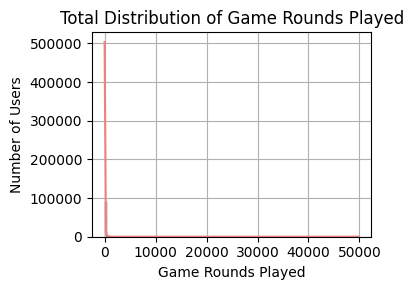

In [70]:
# plot distribution of sum_gamerounds
plt.figure(figsize=(4, 3))
sns.histplot(data=df, x="sum_gamerounds", bins=100, kde=True, color="lightcoral")
plt.title("Total Distribution of Game Rounds Played", fontsize = 12)
plt.xlabel("Game Rounds Played")
plt.ylabel("Number of Users")
plt.grid(True)
plt.tight_layout()
plt.show()

The distribution of the game rounds played across total users is extremely right-skewed, with a majority of users having played a low number of rounds, and a very small number of users having played a large number of rounds. The presence of these outliers are not ideal for modelling and will need to be trimmed.

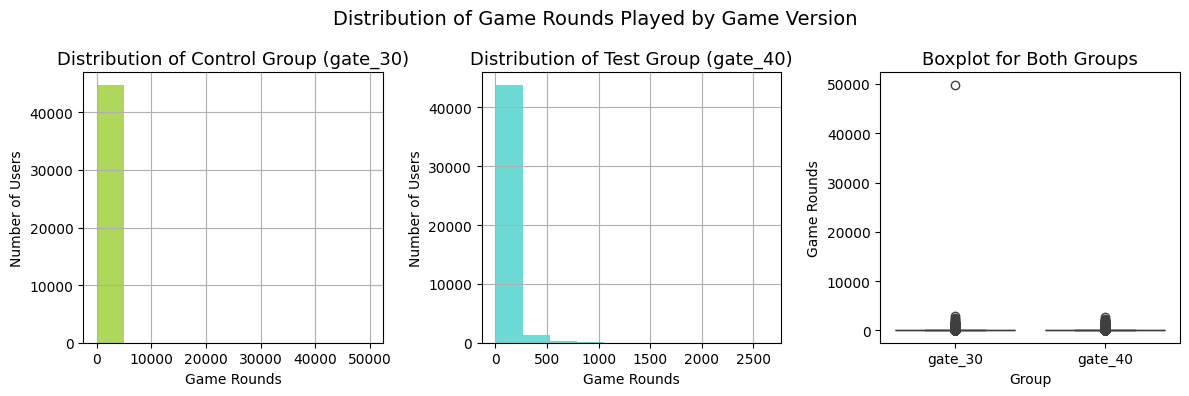

In [68]:
fig, axes = plt.subplots(1, 3, figsize = (12,4))
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "yellowgreen", alpha=0.8)
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "mediumturquoise", alpha=0.8)
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[2])

plt.suptitle("Distribution of Game Rounds Played by Game Version", fontsize = 14)
axes[0].set_title("Distribution of Control Group (gate_30)", fontsize = 13)
axes[0].set_xlabel("Game Rounds")
axes[0].set_ylabel("Number of Users")
axes[1].set_title("Distribution of Test Group (gate_40)", fontsize = 13)
axes[1].set_xlabel("Game Rounds")
axes[1].set_ylabel("Number of Users")
axes[2].set_title("Boxplot for Both Groups", fontsize = 13)
axes[2].set_xlabel("Group")
axes[2].set_ylabel("Game Rounds")

plt.tight_layout()

Both groups are right-skewed, with the control group having an extreme outlier at around 50000 game rounds. Non-parametric testing is likely to be used as the distributions are not normal distributions. 

In [84]:
# ratio of users in retention_1 and retention_7 by group
ret_1 = df.groupby("version")["retention_1"].value_counts().unstack()
ret_7 = df.groupby("version")["retention_7"].value_counts().unstack()

retention_ratio = pd.DataFrame({
    "Retention Ratio after 1 Day": ret_1[True] / (ret_1[True] + ret_1[False]),
    "Retention Ratio after 7 Days": ret_7[True] / (ret_7[True] + ret_7[False])
})

retention_ratio

,Retention Ratio after 1 Day,Retention Ratio after 7 Days
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


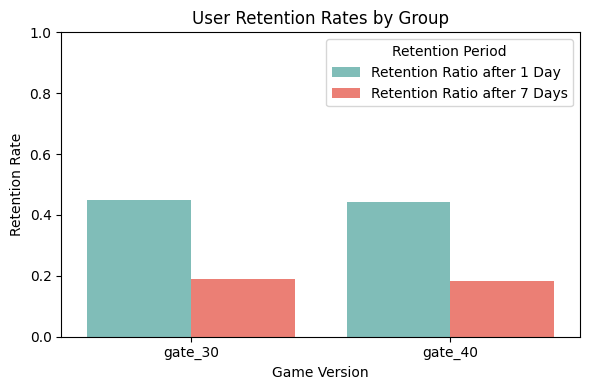

In [91]:
# reformat df to long format
retention_plot_df = retention_ratio.reset_index().melt(
    id_vars="version",
    var_name="Retention Period",
    value_name="Ratio"
)

# plot retention ratios by group
custom_colors = ["#76C7C0", "#FF6F61"]
plt.figure(figsize=(6, 4))
sns.barplot(data=retention_plot_df, x="version", y="Ratio", hue="Retention Period", palette=custom_colors)

plt.title("User Retention Rates by Group")
plt.ylim(0, 1)
plt.ylabel("Retention Rate")
plt.xlabel("Game Version")
plt.legend(title="Retention Period")
plt.tight_layout()
plt.show()

Both groups show relatively short-term retention rates, with rates dropping by half from day 1 to day 7. There seems to be marginal difference between the control and test groups for retention after 1 and 7 days.

### Data preprocessing

In [33]:
# find missing values
df.isnull().any()

userid            False
version           False
sum_gamerounds    False
retention_1       False
retention_7       False
dtype: bool

In [97]:
# remove outliers
cutoff = df["sum_gamerounds"].quantile(0.99) # remove top 1%
outliers = df[df["sum_gamerounds"] > cutoff]
# create new df without outliers
df_test = df[df["sum_gamerounds"] <= cutoff]
print(f"Removed {len(outliers)} outliers which is {len(outliers) / len(df) * 100:.2f}% of the data.")

Removed 898 outliers which is 1.00% of the data.


#### Binary Outcomes with Z-test

In [103]:
## for retention_1
# count of true values in both groups
true_a_1 = df_test[df_test["version"] == "gate_30"]["retention_1"].sum()
true_b_1 = df_test[df_test["version"] == "gate_40"]["retention_1"].sum()

# sample sizes of both groups
n_a = df_test[df_test["version"] == "gate_30"].shape[0]
n_b = df_test[df_test["version"] == "gate_40"].shape[0]

# Run two-proportion z-test
count = [true_a_1, true_b_1]
n_obs = [n_a, n_b]
z_stat, p_value = proportions_ztest(count, n_obs)

print("Z-Test for Proportions (Retention after 1 Day)")
print(f"Proportion (gate_30): {true_a_1 / n_a:.4f}")
print(f"Proportion (gate_40): {true_b_1 / n_b:.4f}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-Test for Proportions (Retention after 1 Day)
Proportion (gate_30): 0.4429
Proportion (gate_40): 0.4369
Z-statistic: 1.8098
P-value: 0.0703


In [104]:
## for retention_7
# count of true values in both groups
true_a_7 = df_test[df_test["version"] == "gate_30"]["retention_7"].sum()
true_b_7 = df_test[df_test["version"] == "gate_40"]["retention_7"].sum()

# sample sizes of both groups
n_a = df_test[df_test["version"] == "gate_30"].shape[0]
n_b = df_test[df_test["version"] == "gate_40"].shape[0]

# Run two-proportion z-test
count = [true_a_7, true_b_7]
n_obs = [n_a, n_b]
z_stat, p_value = proportions_ztest(count, n_obs)

print("Z-Test for Proportions (Retention after 7 Days)")
print(f"Proportion (gate_30): {true_a_7 / n_a:.4f}")
print(f"Proportion (gate_40): {true_b_7 / n_b:.4f}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-Test for Proportions (Retention after 7 Days)
Proportion (gate_30): 0.1825
Proportion (gate_40): 0.1742
Z-statistic: 3.2579
P-value: 0.0011


#### Continuous Outcomes

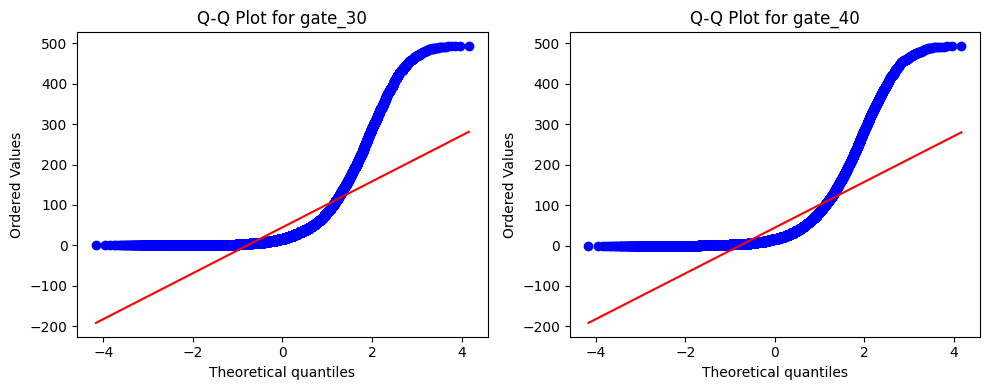

In [124]:
# Q-Q plots to visualise the distribution of control and test groups
# split into control and test group
group_30 = df_test[df_test["version"] == "gate_30"]["sum_gamerounds"].astype(float)
group_40 = df_test[df_test["version"] == "gate_40"]["sum_gamerounds"].astype(float)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Q-Q plot for gate_30
stats.probplot(group_30, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot for gate_30")

# Q-Q plot for gate_40
stats.probplot(group_40, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot for gate_40")

plt.tight_layout()
plt.show()

The Q-Q plots for both gate_30 and gate_40 show that they do not follow a normal distribution.

In [118]:
# define function to run through normality and equal variance checks to find the statistical test to use for sum_gamerounds
def continuous_ab_test(df, group, target_column):
    # split groups
    group_A = df[df[group] == "gate_30"][target_column]
    group_B = df[df[group] == "gate_40"][target_column]

    # check normality with Kolmogorov–Smirnov test
    normal_A = kstest(group_A, 'norm')[1] >= 0.05
    normal_B = kstest(group_B, 'norm')[1] >= 0.05
    
    # if normality holds, check for equal variances with Levene's Test
    if normal_A and normal_B:
        equal_var = stats.levene(group_A, group_B)[1] >= 0.05
        # if equal variances use T-test otherwise use Welch's T-test
        test_type = "T-test" if equal_var else "Welch’s T-test"
        p = stats.ttest_ind(group_A, group_B, equal_var=equal_var).pvalue
    else:
        # if normality doesn't hold, then use non-parametric test Mann-Whitney U
        test_type = "Mann-Whitney U"
        p = stats.mannwhitneyu(group_A, group_B).pvalue

    result = pd.DataFrame({
        "Test Type": [test_type],
        "p-value": [p],
        "Conclusion": ["Reject H0" if p < 0.05 else "Fail to Reject H0"],
        "Comment": ["A/B groups are not similar" if p < 0.05 else "A/B groups are similar"]
    })

    print("H0: Group A == Group B")
    print("H1: Group A != Group B\n")

    return result

In [125]:
# apply A/B test function
continuous_ab_test(df=df_test, group= "version", target_column = "sum_gamerounds")

H0: Group A == Group B
H1: Group A != Group B



,Test Type,p-value,Conclusion,Comment
0,Mann-Whitney U,0.04789,Reject H0,A/B groups are not similar


### Conclusion

We conducted an A/B test to evaluate the impact of a timed gate,which requires users to either wait before progressing or make an in-app purchase to skip, on user retention and the number of game rounds played. The control group encountered the gate at level 30, while the test group encountered it at level 40.

Our analysis found no statistically significant difference in day 1 retention between the two groups (p-value: 0.0703) at a 95% confidence level. However, there was a significant difference in day 7 retention (p-value: 0.0011). This may be due to users not reaching the timed gate on the first day, with the gate only starting to influence behavior later in the week once players had progressed far enough in the game.

We also found a statistically significant difference in the number of game rounds played between the two groups (p-value: 0.04789), indicating that placing the timed gate later in the game may enhance user engagement.